In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('cleaned_datasets/users_details_dataset_cleaned.csv')
df['Birthday'] = pd.to_datetime(df['Birthday'])
df['Birthday_year'] = df['Birthday'].dt.year
current_year = datetime.now().year
df['age'] = current_year - df['Birthday_year']
df['completion_rate'] = df.apply(lambda row: 0 if row['Completed'] == 0 or row['Total Entries'] == 0 else row['Completed'] / row['Total Entries'], axis=1)
df = df[['age', 'Days Watched', 'Completed', 'Total Entries', 'completion_rate']]
print(df.head())


   age  Days Watched  Completed  Total Entries  completion_rate
0   39         142.3      233.0          399.0         0.583960
1   36          73.1       94.0          138.0         0.681159
2   36         142.5      298.0          392.0         0.760204
3   35          47.0      153.0          316.0         0.484177
4   38         138.5      260.0          378.0         0.687831


In [3]:
def load_and_preprocess_data(df):
    
    features = ['age', 'Days Watched', 'Completed', 'Total Entries']
    target = 'completion_rate'
    
    X = df[features]
    y = df[target]

    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    
    for column in X.columns:
        percentile_99 = X[column].quantile(0.99)
        X[column] = X[column].clip(upper=percentile_99)
    
    y = y.clip(0, 1)
    
    return X, y

def train_and_predict(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return X_test, y_test, y_pred, rmse, r2, feature_importance

X, y = load_and_preprocess_data(df)
X_test, y_test, y_pred, rmse, r2, feature_importance = train_and_predict(X, y)

def calculate_metrics(y_test, y_pred, thresholds=[0.05, 0.1, 0.15]):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    accuracies = {}

    for threshold in thresholds:
        within_threshold = np.abs(y_test - y_pred) <= threshold
        accuracy = np.mean(within_threshold) * 100
        accuracies[f'accuracy_{threshold}'] = accuracy
    
    print("\n---Model Performance Metrics---")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    print("\n---Accuracy by Threshold---")
    for threshold, accuracy in accuracies.items():
        print(f"Accuracy (within {float(threshold.split('_')[1]):.2f}): {accuracy:.2f}%")
    
    errors = np.abs(y_test - y_pred)
    print("\n--- Error Distribution ---")
    print(f"Median Error: {np.median(errors):.4f}")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Maximum Error: {np.max(errors):.4f}")
    
    # Count data points by error ranges
    print("\n--- Data Distribution by Error Range ---")
    error_ranges = [0.05, 0.1, 0.15, 0.2, float('inf')]
    prev_range = 0
    for err_range in error_ranges:
        mask = (errors > prev_range) & (errors <= err_range)
        percentage = np.mean(mask) * 100
        print(f"Error Range {prev_range:.2f}~{err_range if err_range != float('inf') else 'inf'}: {percentage:.2f}%")
        prev_range = err_range

calculate_metrics(y_test, y_pred)


---Model Performance Metrics---
RMSE: 0.0981
R² Score: 0.8137
MAE: 0.0594

---Accuracy by Threshold---
Accuracy (within 0.05): 65.04%
Accuracy (within 0.10): 80.12%
Accuracy (within 0.15): 87.89%

--- Error Distribution ---
Median Error: 0.0266
Mean Error: 0.0594
Maximum Error: 0.6613

--- Data Distribution by Error Range ---
Error Range 0.00~0.05: 61.88%
Error Range 0.05~0.1: 15.08%
Error Range 0.10~0.15: 7.77%
Error Range 0.15~0.2: 4.46%
Error Range 0.20~inf: 7.65%



Feature Importance Visualization


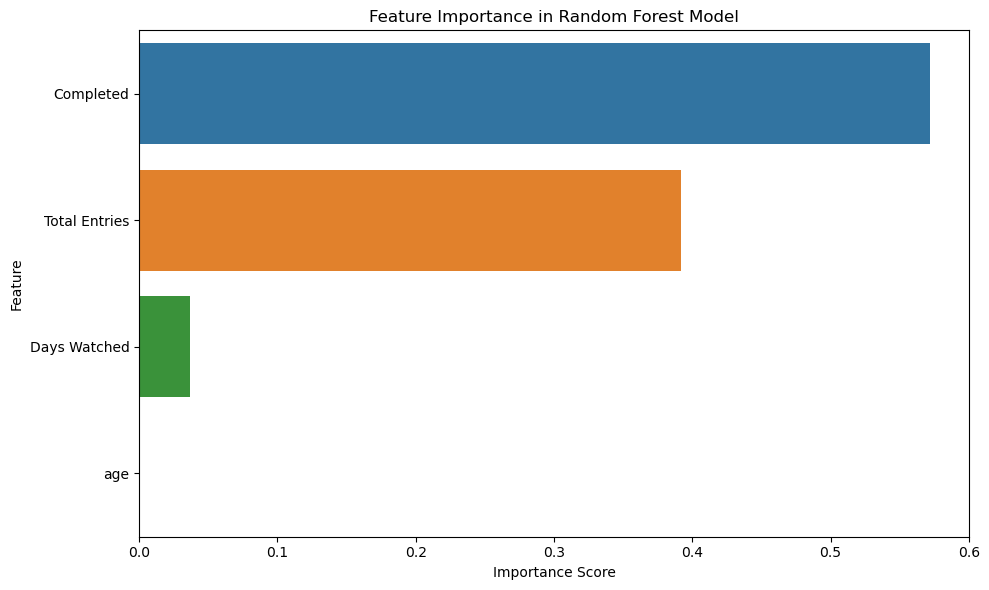


Prediction Results Visualization


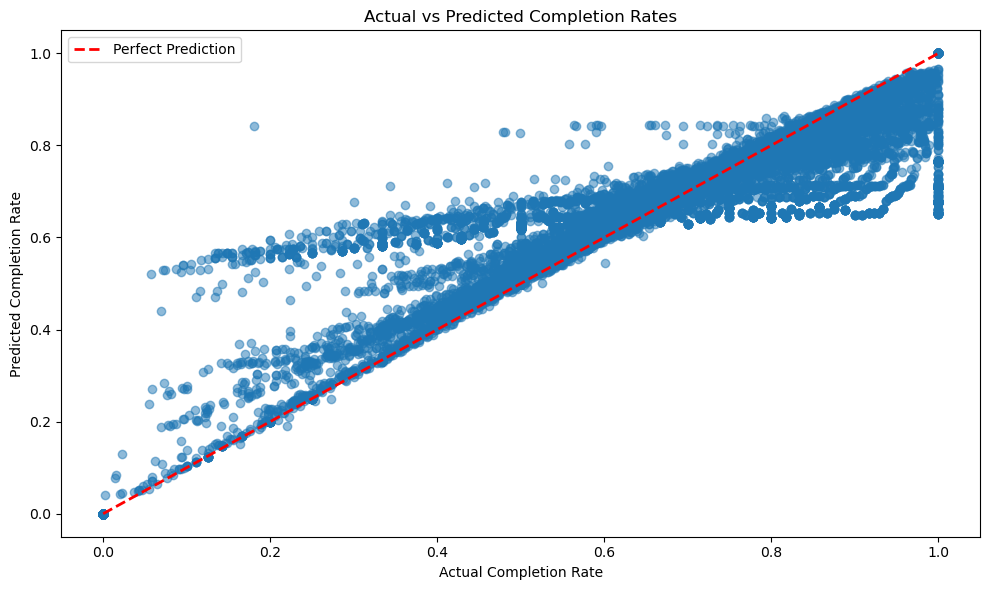

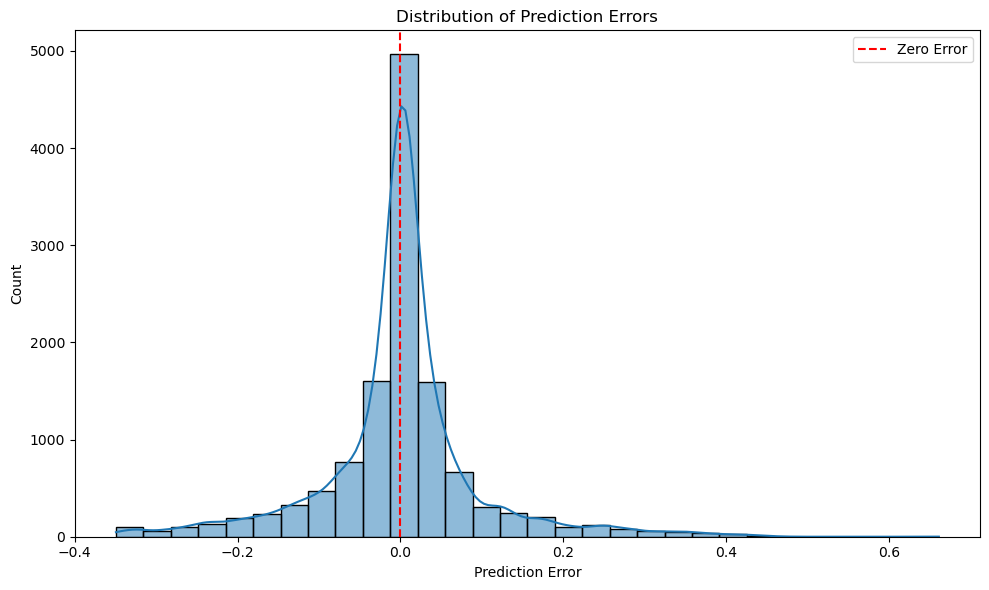


Correlation Matrix


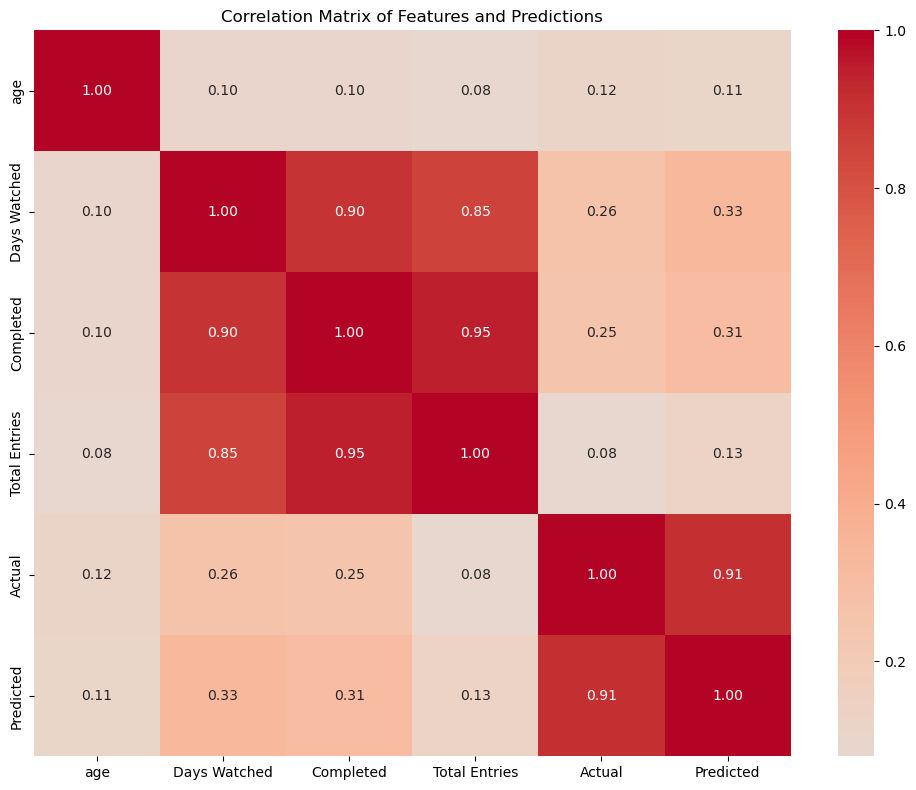


Actual vs Predicted Distribution


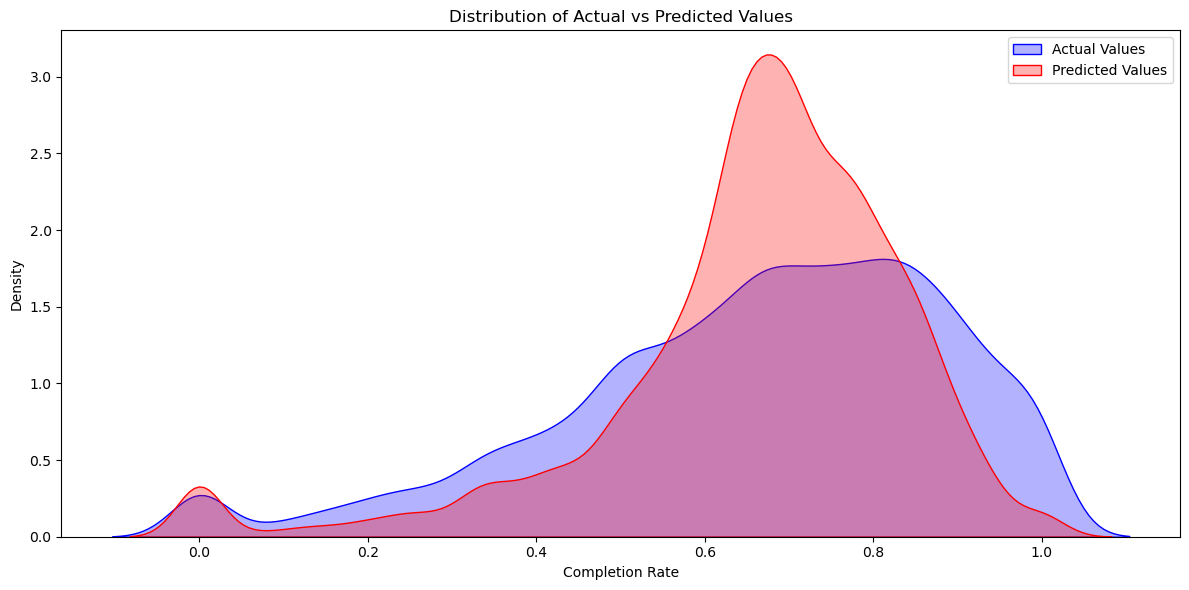


Error Distribution by Feature Ranges


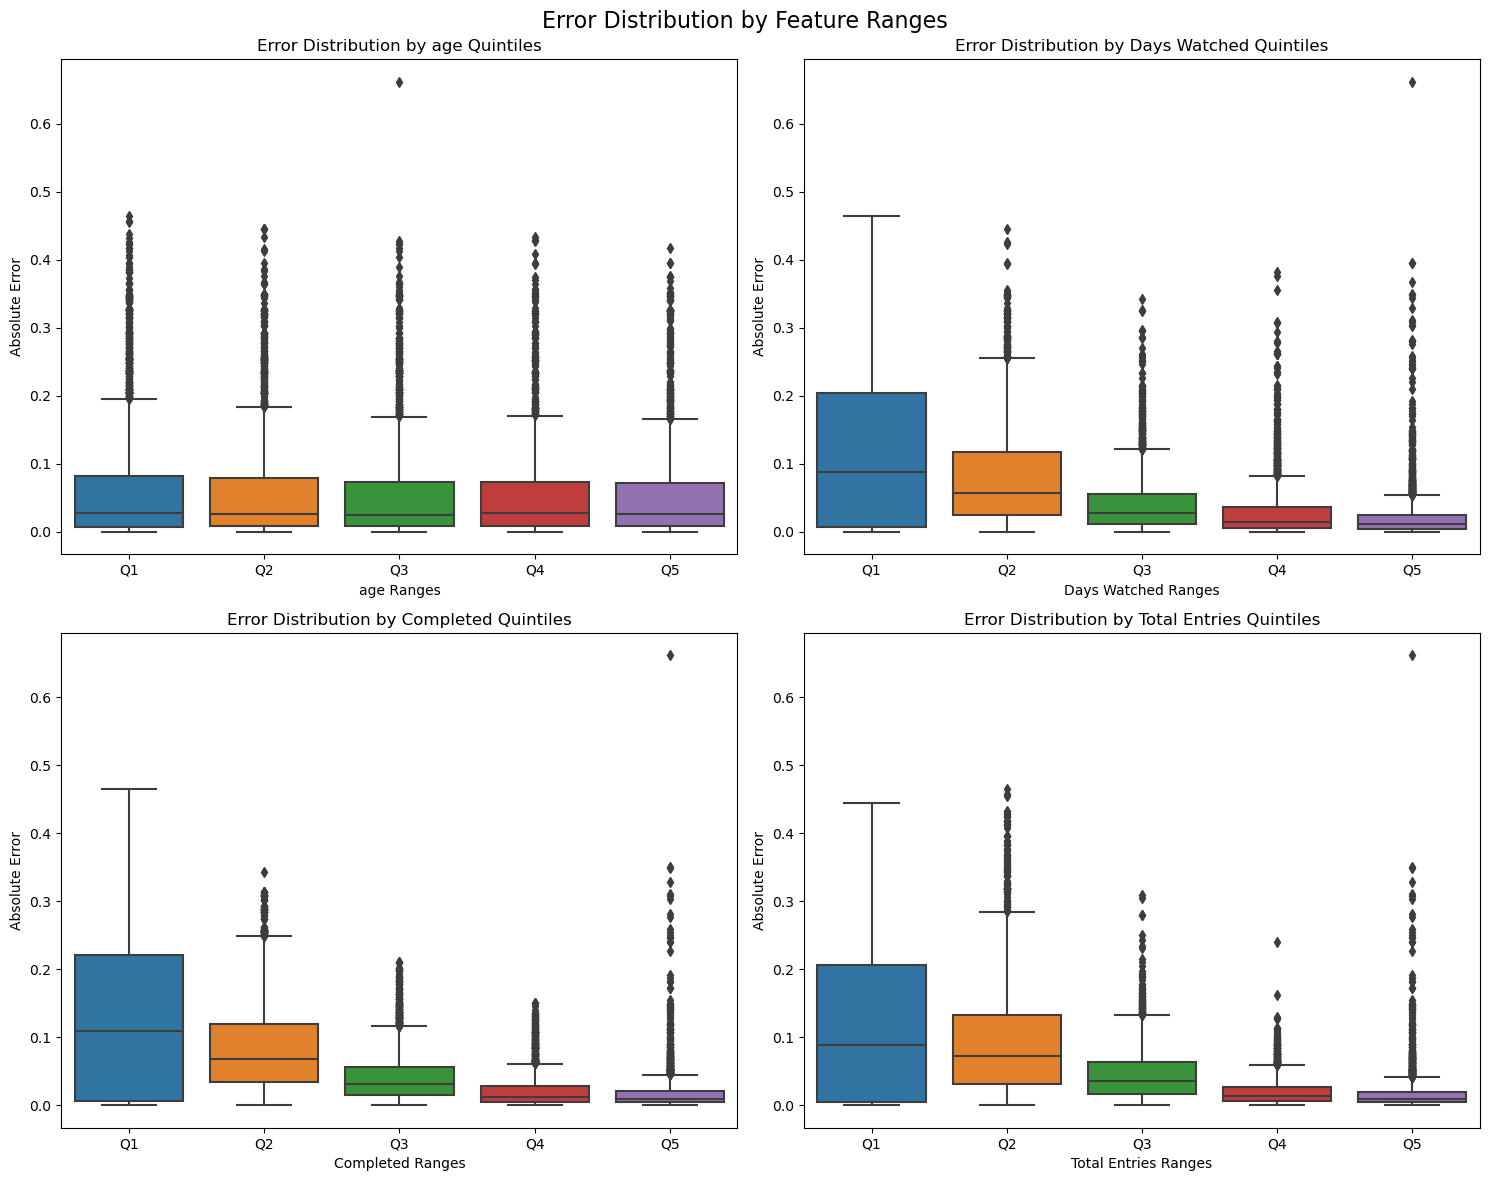


Feature Interactions and Errors


<Figure size 1500x1000 with 0 Axes>

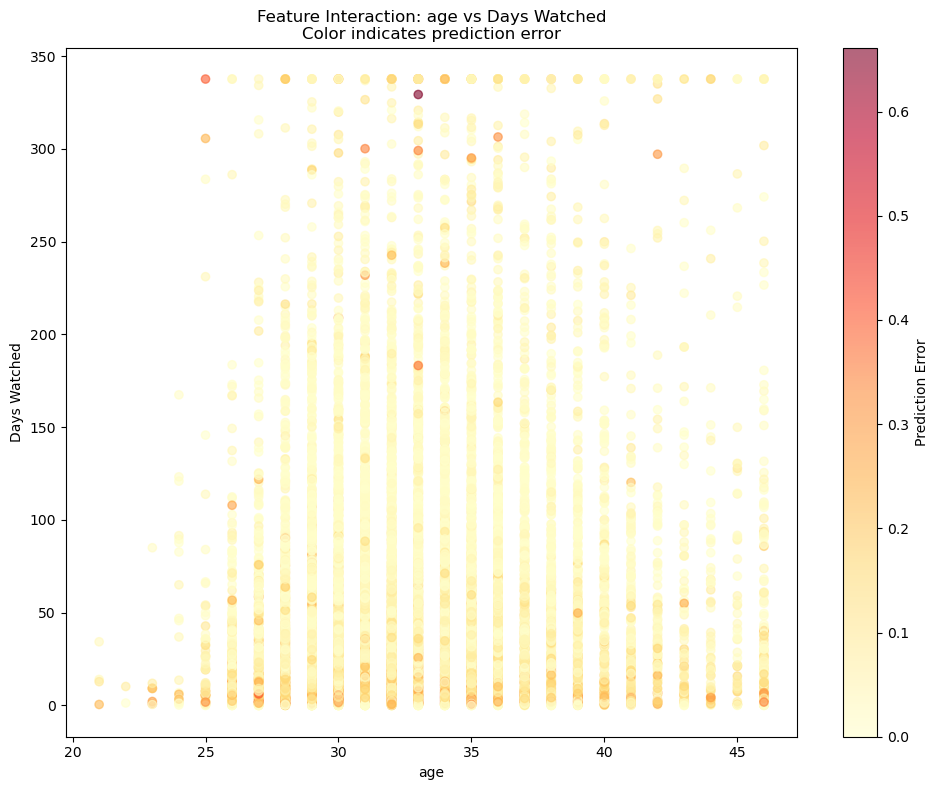

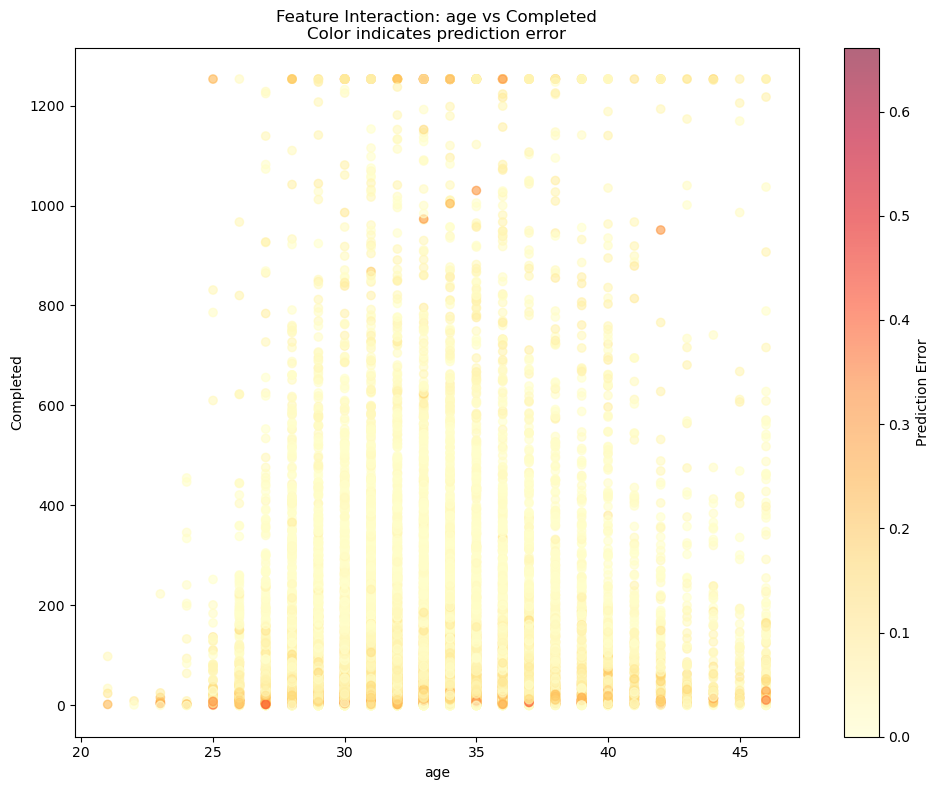

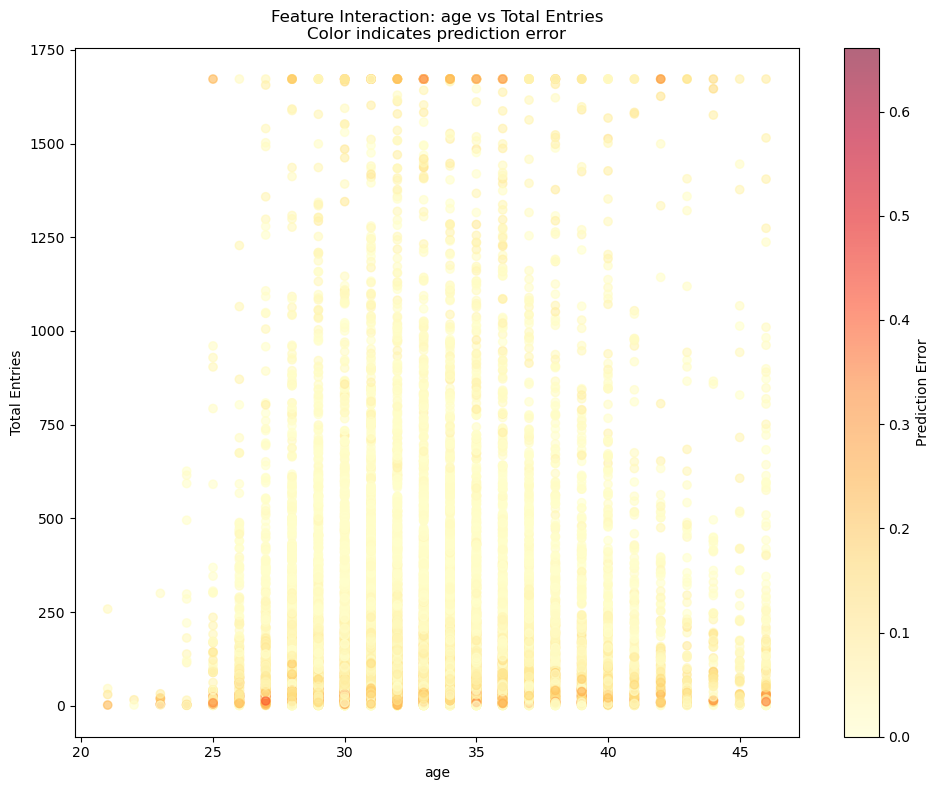

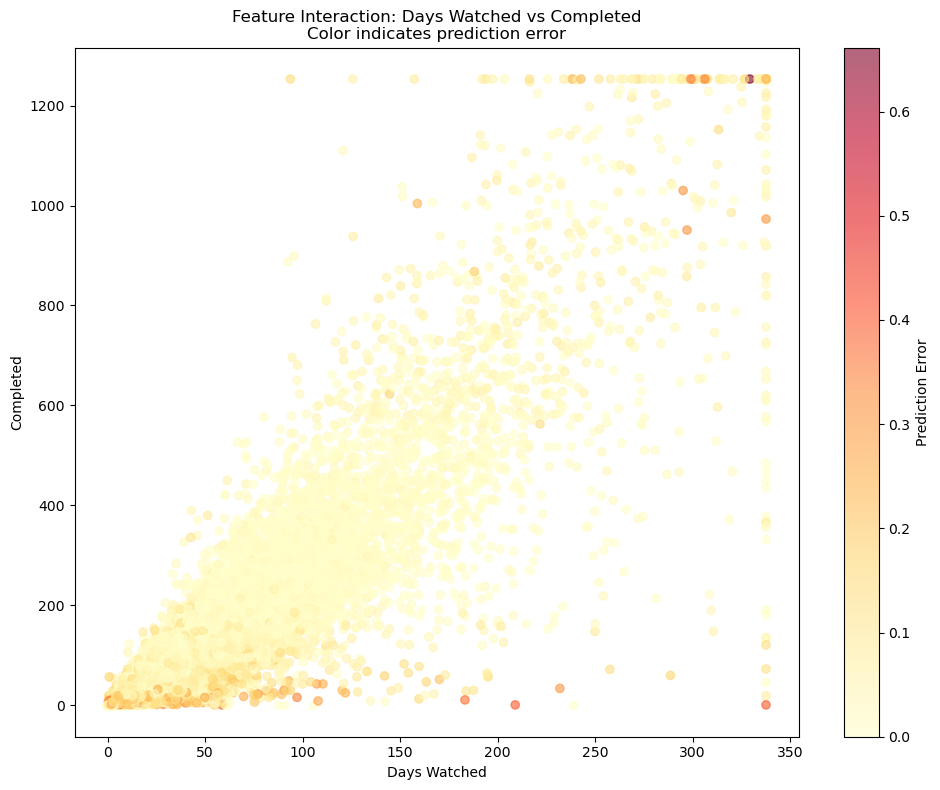

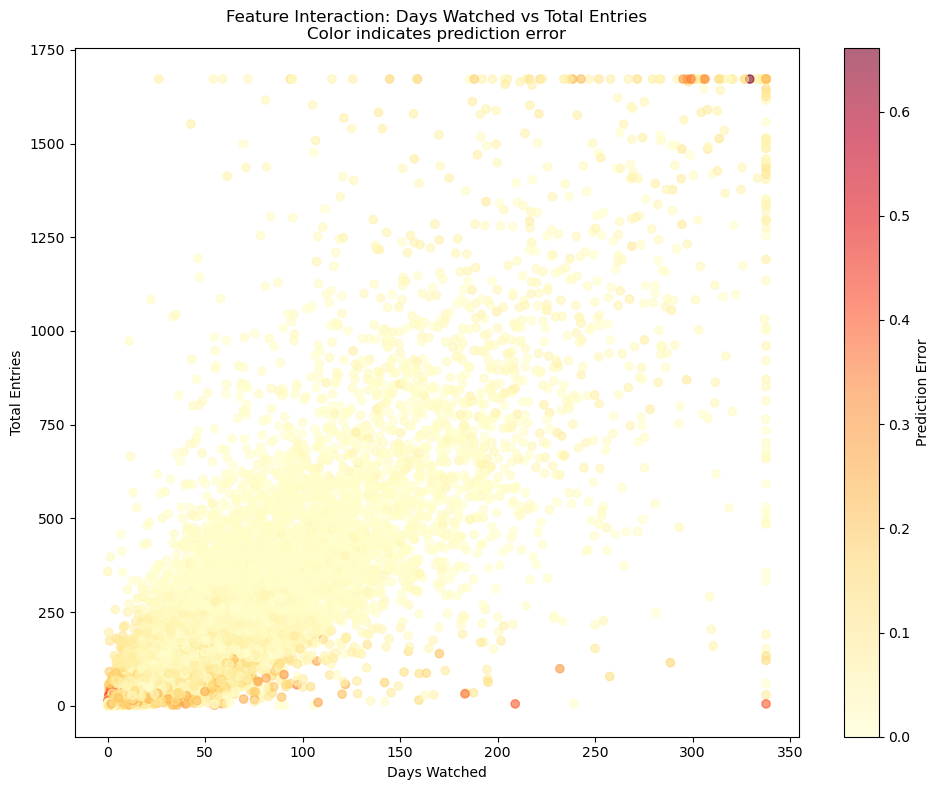

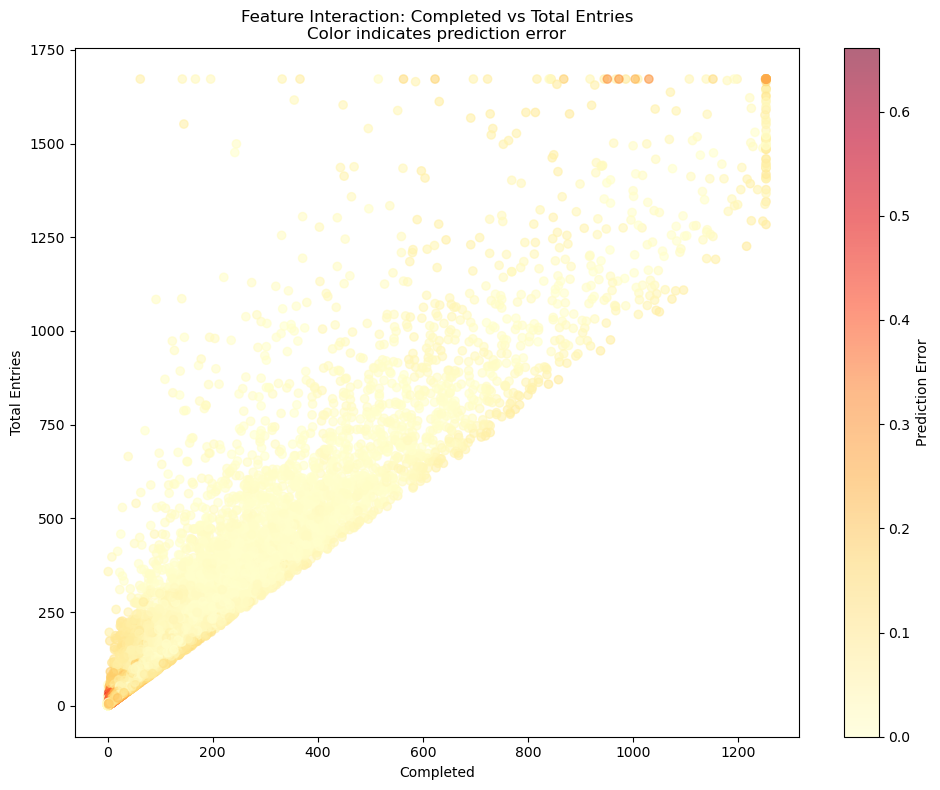


Residual Analysis


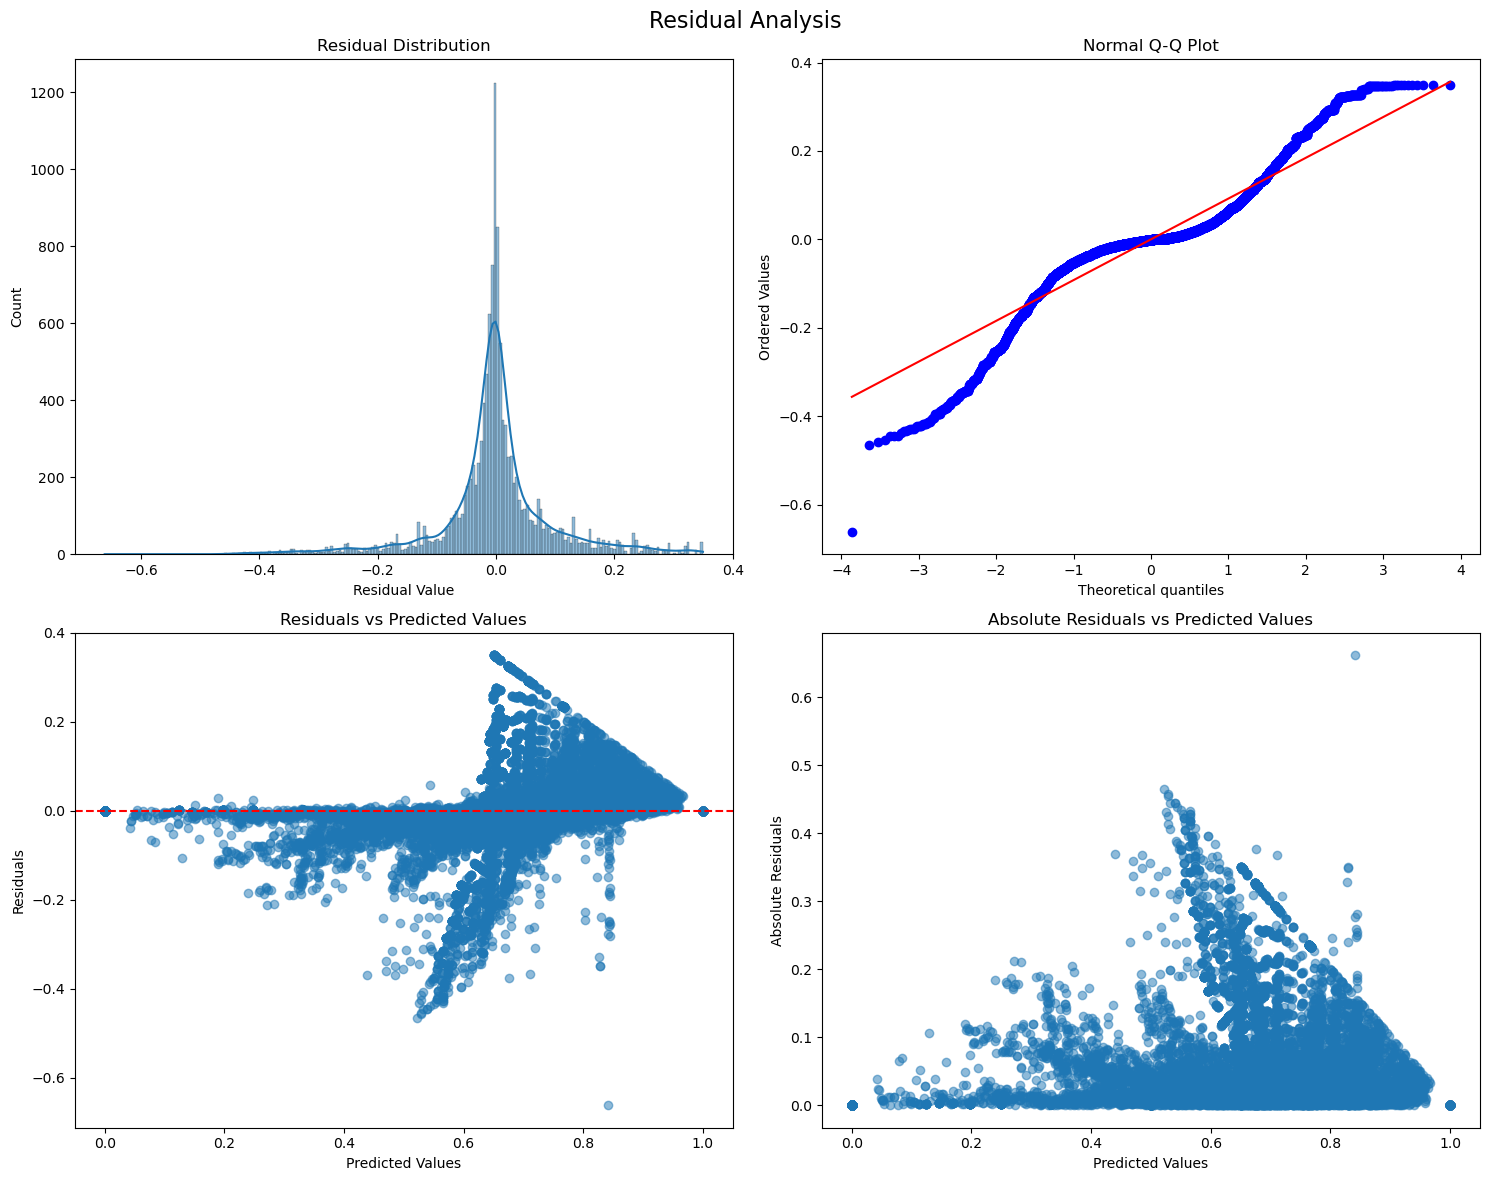


Cumulative Gains


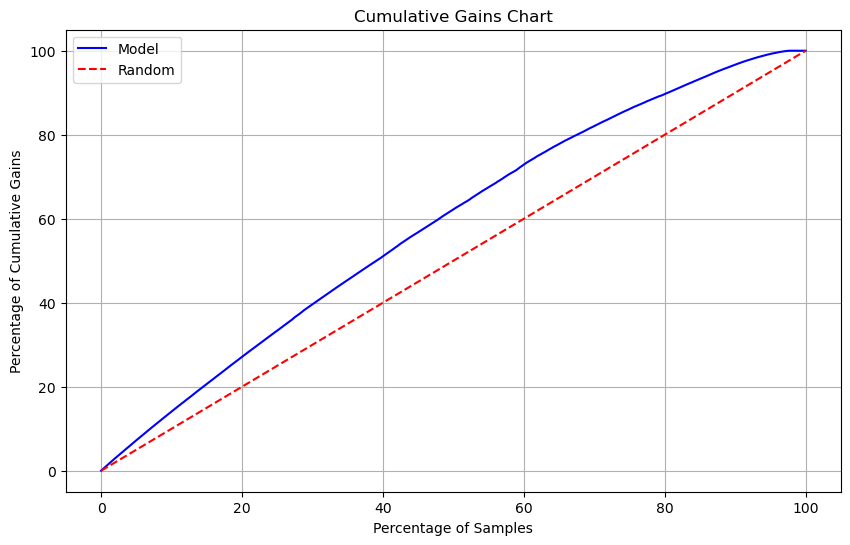

In [4]:
def visualize_feature_importance(feature_importance):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in Random Forest Model')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def visualize_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Completion Rate')
    plt.ylabel('Predicted Completion Rate')
    plt.title('Actual vs Predicted Completion Rates')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    errors = y_pred - y_test
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30)
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_correlation_matrix(X_test, y_test, y_pred):
    corr_df = X_test.copy()
    corr_df['Actual'] = y_test
    corr_df['Predicted'] = y_pred
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Features and Predictions')
    plt.tight_layout()
    plt.show()

def visualize_prediction_distribution(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=y_test, label='Actual Values', color='blue', fill=True, alpha=0.3)
    sns.kdeplot(data=y_pred, label='Predicted Values', color='red', fill=True, alpha=0.3)
    plt.title('Distribution of Actual vs Predicted Values')
    plt.xlabel('Completion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_error_boxplots(X_test, y_test, y_pred):
    errors = np.abs(y_test - y_pred)
    results_df = pd.DataFrame(X_test.copy())
    results_df['Error'] = errors
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Error Distribution by Feature Ranges', fontsize=16)
    
    for idx, col in enumerate(X_test.columns):
        row = idx // 2
        col_idx = idx % 2
        
        results_df[f'{col}_bin'] = pd.qcut(results_df[col], q=5, labels=[f'Q{i+1}' for i in range(5)])
        
        sns.boxplot(data=results_df, x=f'{col}_bin', y='Error', ax=axes[row, col_idx])
        axes[row, col_idx].set_title(f'Error Distribution by {col} Quintiles')
        axes[row, col_idx].set_xlabel(f'{col} Ranges')
        axes[row, col_idx].set_ylabel('Absolute Error')
        
    plt.tight_layout()
    plt.show()

def visualize_feature_interactions(X_test, y_test, y_pred):
    errors = np.abs(y_test - y_pred)
    plt.figure(figsize=(15, 10))
    
    features = X_test.columns
    for i, feat1 in enumerate(features):
        for j, feat2 in enumerate(features):
            if i < j:
                plt.figure(figsize=(10, 8))
                scatter = plt.scatter(X_test[feat1], X_test[feat2], c=errors, cmap='YlOrRd', alpha=0.6)
                plt.colorbar(scatter, label='Prediction Error')
                plt.xlabel(feat1)
                plt.ylabel(feat2)
                plt.title(f'Feature Interaction: {feat1} vs {feat2}\nColor indicates prediction error')
                plt.tight_layout()
                plt.show()

def visualize_residual_analysis(y_test, y_pred):
    
    residuals = y_test - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Residual Analysis', fontsize=16)
    
    sns.histplot(residuals, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Residual Distribution')
    axes[0, 0].set_xlabel('Residual Value')
    
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot')
    
    axes[1, 0].scatter(y_pred, residuals, alpha=0.5)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Predicted Values')
    
    axes[1, 1].scatter(y_pred, np.abs(residuals), alpha=0.5)
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('Absolute Residuals')
    axes[1, 1].set_title('Absolute Residuals vs Predicted Values')
    
    plt.tight_layout()
    plt.show()

def visualize_cumulative_gains(y_test, y_pred):
    df = pd.DataFrame({'actual': y_test, 'pred': y_pred})
    df = df.sort_values('pred', ascending=False)
    
    total_actual = df['actual'].sum()
    cum_gains = np.cumsum(df['actual']) / total_actual * 100
    percentiles = np.arange(len(df)) / len(df) * 100
    
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, cum_gains, label='Model', color='blue')
    plt.plot([0, 100], [0, 100], '--', label='Random', color='red')
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Percentage of Cumulative Gains')
    plt.title('Cumulative Gains Chart')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_all_visualizations(X_test, y_test, y_pred, feature_importance):
    print("\nFeature Importance Visualization")
    visualize_feature_importance(feature_importance)
    
    print("\nPrediction Results Visualization")
    visualize_predictions(y_test, y_pred)
    
    print("\nCorrelation Matrix")
    visualize_correlation_matrix(X_test, y_test, y_pred)

    print("\nActual vs Predicted Distribution")
    visualize_prediction_distribution(y_test, y_pred)
    
    print("\nError Distribution by Feature Ranges")
    visualize_error_boxplots(X_test, y_test, y_pred)
    
    print("\nFeature Interactions and Errors")
    visualize_feature_interactions(X_test, y_test, y_pred)
    
    print("\nResidual Analysis")
    visualize_residual_analysis(y_test, y_pred)
    
    print("\nCumulative Gains")
    visualize_cumulative_gains(y_test, y_pred)

create_all_visualizations(X_test, y_test, y_pred, feature_importance)

EDA Part
- Hypothesis: The completion rate ('Completed / Total Entries') is expected to increase with both higher age group concentrations and longer Days Watched values.
- Algorithm: Random Forest
- Resource(Cite): https://en.wikipedia.org/wiki/Random_forest

# -------------------------------------------------------------------------
Justification for why chose Random Forest

Random Forest is particularly well-suited for anime completion rate prediction task for several reasons. The model efficiently handles non-linear relationships that likely exist between features like age groups, Days Watched, and completion rates. It naturally captures complex interactions between these variables without requiring explicit specification. The hypothesis I stated suggests that both higher age group numbers and increased Days Watched correlate with higher completion rates. Random Forest can effectively test this hypothesis through its ensemble learning approach and provide feature importance metrics to validate these relationships. The model's ability to handle varying scales among features without extensive preprocessing is also big advantages. Random Forest also offers strong interpretability through feature importance rankings, which is crucial for understanding whether age groups or Days Watched has a stronger influence on completion rates. This interpretability makes it more practical than alternatives like neural networks or linear regression, which might either be too complex or too restrictive for this specific prediction task. The model's ensemble approach helps mitigate noise in the data and maintain high prediction accuracy. Its ability to handle potential group effects in age categories and varying viewing patterns makes it particularly suited for this specific anime-watching behavior analysis.

# -------------------------------------------------------------------------
Tune/train the model

model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

The model tuning and training process in the code consists of several key steps that work together to optimize the anime completion rate prediction. Random Forest model is initially defined with predefined hyperparameters to include 100 trees in the forest, a maximum depth of 10 for each tree, a minimum of 5 samples required for node splitting, and a minimum of 2 samples at each leaf node.
The training process begins by splitting the dataset into a 70% training set and a 30% test set. Before training, I apply StandardScaler to normalize features, which helps prevent any single feature from dominating the model due to its scale.
I could enhance model performance through GridSearchCV, which would systematically explore different combinations of parameters. This would contain testing various numbers of trees (50, 100, 200), different maximum depths (5, 10, 15, or unlimited), and different minimum sample requirements for splits and leaves.
The model's training process utilizes the entire training dataset to build multiple decision trees limplicitly. This ensemble approach helps prevent overfitting and captures complex patterns in the anime viewing and completion data, as evidenced by strong R² score of 0.8137.
For further optimization, I could implement cross-validation during the training process, which would provide more robust parameter selection and better generalization to new data. This would involve dividing the training data into multiple folds and validating the model's performance across these different subsets.



# -------------------------------------------------------------------------
The effectiveness of the algorithm

The Random Forest model shows strong performance with an RMSE of 0.0981 and an R² score of 0.8137. The MAE of 0.0594 suggests that predictions deviate about 6% from actual values on average.
The accuracy metrics demonstrate impressive prediction precision with 65.04% of predictions within 0.05 of the actual values. 80.12% of predictions are within 0.10 of actual values, and a substantial 87.89% within 0.15. It showing high reliability in the model's predictions.
In the error distribution, the median error of 0.0266 is notably lower than the mean error of 0.0594. While the maximum error reaches 0.6613.
The error range distribution is particularly impressive because it has 61.88% of predictions with errors less than 0.05, which represents excellent accuracy. over 76(61 + 15)% of all predictions have errors below 0.10. Only 7.65% of predictions have errors above 0.20 and indicate that severe mispredictions are relatively rare.
These metrics collectively suggest that the Random Forest model is performing very well for this anime completion rate prediction task.

# -------------------------------------------------------------------------
Insights gained from the algorithm

I can identify which factors most strongly influence completion rates through the feature importance visualization provided in the code. This directly addresses my initial hypothesis about the relationship between age groups, Days Watched, and completion rates, though the specific importance rankings would need to be examined in the visualization output.
